# Generative Adversarial Networks (GAN)
https://nn.labml.ai/gan/original/index.html

In [7]:
import torch
import torch.nn as nn
import torch.utils.data
from labml_helpers.module import Module

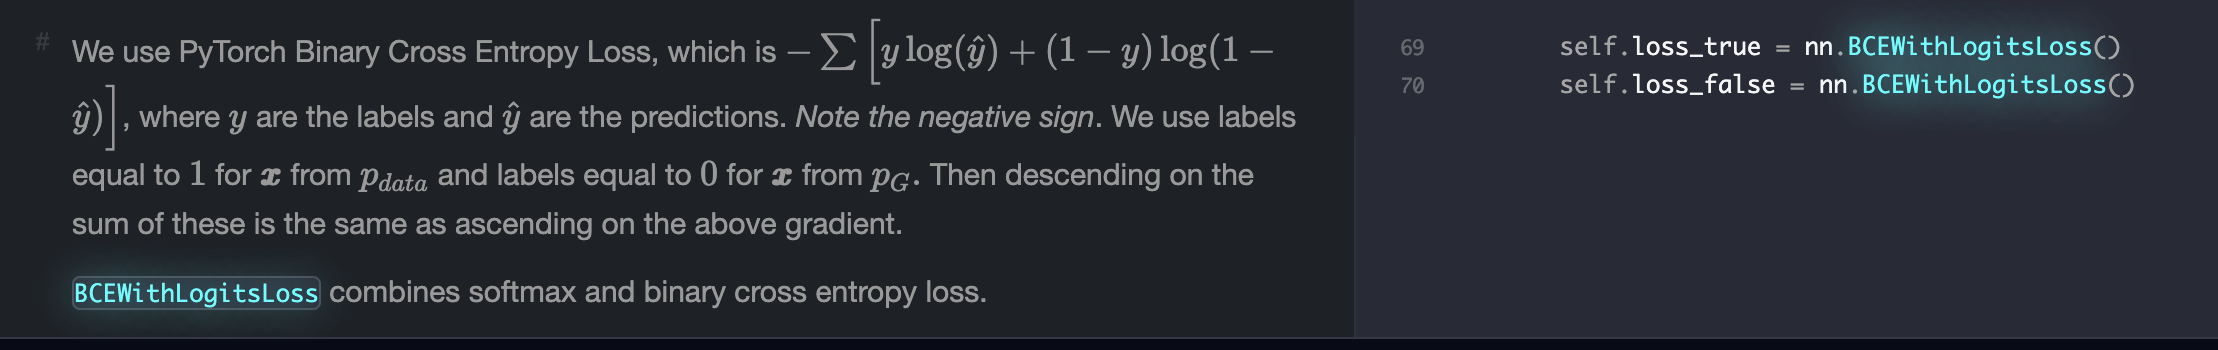

In [12]:
class DiscriminatorLogitsLoss(Module):
    def __init__(self, smoothing: float = 0.2):
        super().__init__() 

        # see above
        self.loss_true = nn.BCEWithLogitsLoss()
        self.loss_false = nn.BCEWithLogitsLoss()
        
        # We use label smoothing because it seems to work better in some cases
        self.smoothing = smoothing

        # Labels are registered as buffered and persistence is set to False .
        self.register_buffer('labels_true', _create_labels(256, 1.0 - smoothing, 1.0), False)
        self.register_buffer('labels_false', _create_labels(256, 0.0, smoothing), False)

    def forward(self, logits_true: torch.Tensor, logits_false: torch.Tensor):
        
        if len(logits_true) > len(self.labels_true):
            self.register_buffer("labels_true",
                                 _create_labels(len(logits_true), 1.0 - self.smoothing, 1.0, logits_true.device), False)
        if len(logits_false) > len(self.labels_false):
            self.register_buffer("labels_false",
                                 _create_labels(len(logits_false), 0.0, self.smoothing, logits_false.device), False)

        return (self.loss_true(logits_true, self.labels_true[:len(logits_true)]),
                self.loss_false(logits_false, self.labels_false[:len(logits_false)]))
        

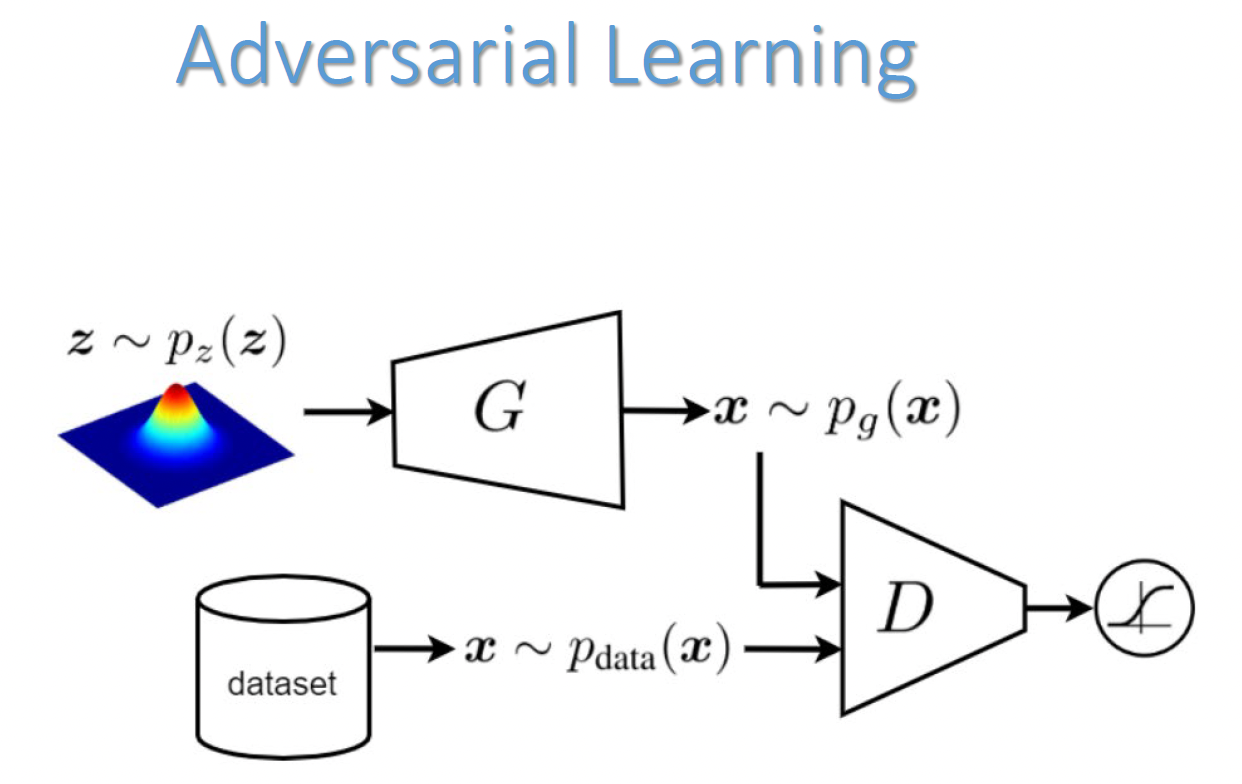

In [13]:
class GeneratorLogitsLoss(Module):
    def __init__(self, smoothing: float = 0.2):
        super().__init__()
        self.loss_true = nn.BCEWithLogitsLoss()
        self.smoothing = smoothing
        self.register_buffer('fake_labels', _create_labels(256, 1.0 - smoothing, 1.0), False)
    def forward(self, logits: torch.Tensor):
        if len(logits) > len(self.fake_labels):
            self.register_buffer("fake_labels",
                                 _create_labels(len(logits), 1.0 - self.smoothing, 1.0, logits.device), False)
            
        return self.loss_true(logits, self.fake_labels[:len(logits)])
        
    # Create smoothed labels
    def _create_labels(n: int, r1: float, r2: float, device: torch.device = None):
         return torch.empty(n, 1, requires_grad=False, device=device).uniform_(r1, r2)

# 常见问题： 



Mode Collapse 是生成对抗网络（GAN）训练中的一个常见问题，指的是生成器（Generator）在训练过程中倾向于生成非常相似或重复的样本，导致多样性不足。换句话说，生成器“崩溃”到只生成少数几种模式（样本），而无法捕捉到真实数据分布的全部多样性。

Mode Collapse 的原因
生成器和判别器的失衡：

如果判别器（Discriminator）过于强大，生成器可能会找到一种“欺骗”判别器的简单方式，即反复生成相同的样本。

生成器可能会放弃探索其他模式，只专注于生成少数几种能够骗过判别器的样本。

优化困难：

GAN 的训练是一个极小极大博弈问题，生成器和判别器的目标函数相互对抗，可能导致训练不稳定。

生成器可能会陷入局部最优，只生成少数几种样本。

数据分布的复杂性：

如果真实数据的分布非常复杂（多模态），生成器可能难以学习到所有模式，从而倾向于生成少数几种样本。

Mode Collapse 的表现
生成器生成的样本缺乏多样性，例如在生成图像时，可能只生成同一张或少数几张类似的图像。

生成器的输出在训练过程中逐渐变得单一。

解决 Mode Collapse 的方法
改进网络架构：

使用更复杂的生成器和判别器架构，例如深度卷积网络（DCGAN）或基于注意力机制的模型。

引入正则化技术，如谱归一化（Spectral Normalization）。

改进损失函数：

使用 Wasserstein GAN（WGAN）或 WGAN-GP，通过改进损失函数来缓解模式崩溃。

使用带有梯度惩罚的损失函数（Gradient Penalty）来稳定训练。

多样性和正则化：

在损失函数中加入多样性惩罚项，鼓励生成器生成多样化的样本。

使用 Mini-batch Discrimination（小批量判别），让判别器能够感知整个批次的样本分布，从而鼓励生成器生成多样化的样本。

调整训练策略：

使用不同的优化器（如 Adam 或 RMSProp）并调整超参数（如学习率）。

采用交替训练策略，确保生成器和判别器的能力平衡。

其他改进方法：

使用多生成器或多判别器架构（如 MGAN 或 MAD-GAN）。

引入外部信息（如类别标签）来指导生成过程（如 Conditional GAN）。

总结
Mode Collapse 是 GAN 训练中的一个重要挑战，会导致生成样本缺乏多样性。通过改进网络架构、损失函数、训练策略等方法，可以有效缓解这一问题，从而提高生成样本的质量和多样性。